# Basic Setting

In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import platform

if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False 

# DB Connect

In [3]:
# connect = pymysql.connect(
#     host='192.168.0.132', 
#     user='newdeal', 
#     password='newdealtptp',
#     db='newdealdb', 
#     charset='utf8'
# )
 
connect = pymysql.connect(
    host='localhost', 
    user='root', 
    password='1234',
    db='newdealdb', 
    charset='utf8'
)
 
    
cursor = connect.cursor()

sql = "SELECT id, category_id, lat, lng, region FROM tptp"
cursor.execute(sql)
 
rows = cursor.fetchall()

# cursor.close()

In [4]:
all_df = pd.DataFrame(rows, columns=["id", "category", "lat", "lng", "region"])
all_df["region"] = all_df["region"].str.strip()
all_df.head()

id category        lat         lng region
0  KCLANPO22N000000001      CT1  35.729306  128.932090   경상북도
1  KCLANPO22N000000002      CT2  35.018297  127.171274   전라남도
2  KCLANPO22N000000003      CT2  34.943969  128.395593   경상남도
3  KCLANPO22N000000004      CT2  37.428729  126.934391    경기도
4  KCLANPO22N000000005      CT2  35.745312  127.046958   전라북도

In [5]:
seoul_df = all_df[all_df["region"]=="서울특별시"]
print(len(seoul_df))

1796


# Test Cluster Algorithm

## initial visualization

<AxesSubplot: xlabel='lng', ylabel='lat'>

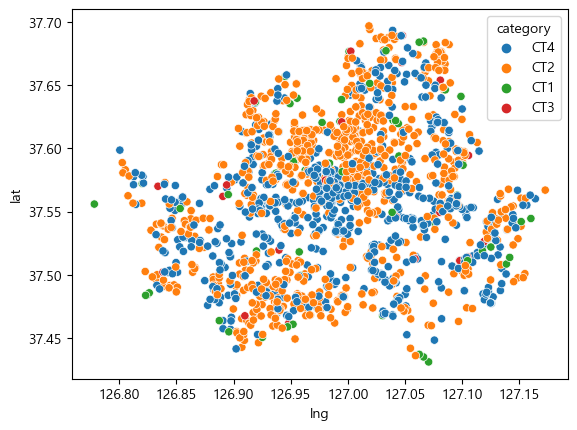

In [6]:
sns.scatterplot(data=seoul_df, x="lng", y="lat", hue="category")

## Kmeans

In [7]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=50)
kmean_groups = kmean.fit_predict(seoul_df[["lng", "lat"]])

seoul_df["kmeans"] = kmean_groups
seoul_df = seoul_df.astype({"kmeans": str})
kmeans_centroids = seoul_df.groupby("kmeans").mean(numeric_only=True)

D:\study\Anaconda\envs\multicampus\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\ParkMinjeong\AppData\Local\Temp\ipykernel_31888\2378148256.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seoul_df["kmeans"] = kmean_groups


## DBSCAN

In [8]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.01, min_samples=5)
dbscan_groups = dbscan.fit_predict(seoul_df[["lng", "lat"]])

seoul_df["dbscan"] = dbscan_groups
seoul_df = seoul_df.astype({"dbscan": str})
dbscan_centroids = seoul_df.groupby("dbscan").mean(numeric_only=True)
print(np.unique(dbscan_groups))

[-1  0  1  2  3  4  5  6  7  8  9 10]


## KMedoids

In [9]:
from sklearn_extra.cluster import KMedoids

kmedois = KMedoids(n_clusters=50, method="pam")
kmedois_groups = kmedois.fit_predict(seoul_df[["lng", "lat"]])

seoul_df["kmedois"] = kmedois_groups
seoul_df = seoul_df.astype({"kmedois": str})
kmedois_centroids = seoul_df.groupby("kmedois").median(numeric_only=True)

## Comparing Algorithm

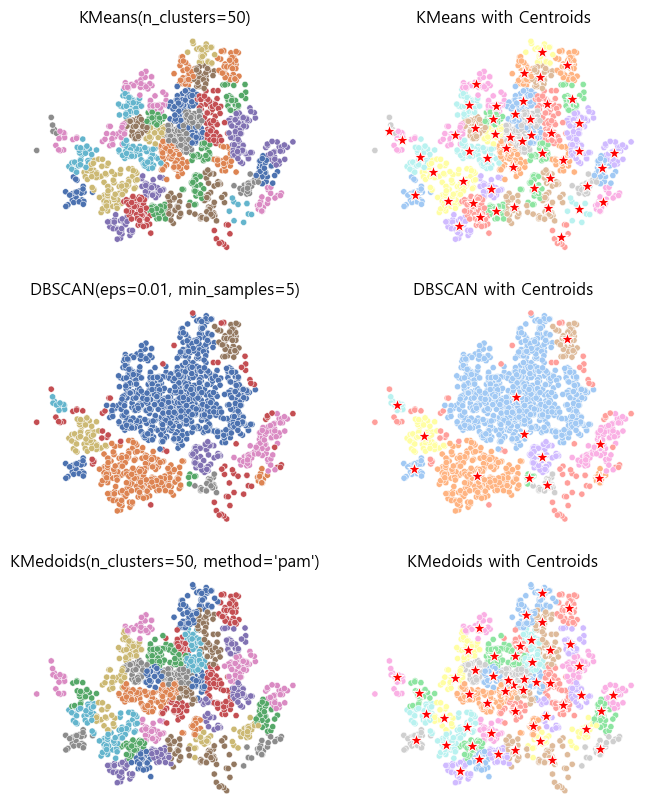

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,10))

sns.scatterplot(ax=axes[0,0], data=seoul_df, x="lng", y="lat", hue="kmeans", legend=False, palette="deep", s=20)
axes[0,0].set_title("KMeans(n_clusters=50)")
axes[0,0].axis("off")

sns.scatterplot(ax=axes[0,1], data=seoul_df, x="lng", y="lat", hue="kmeans", legend=False, palette="pastel", s=20)
sns.scatterplot(ax=axes[0,1],data=kmeans_centroids, x="lng", y="lat", marker="*", c="red", s=100)
axes[0,1].set_title("KMeans with Centroids")
axes[0,1].axis("off")

sns.scatterplot(ax=axes[1,0], data=seoul_df, x="lng", y="lat", hue="dbscan", legend=False, palette="deep", s=20)
axes[1,0].set_title("DBSCAN(eps=0.01, min_samples=5)")
axes[1,0].axis("off")

sns.scatterplot(ax=axes[1,1], data=seoul_df, x="lng", y="lat", hue="dbscan", legend=False, palette="pastel", s=20)
sns.scatterplot(ax=axes[1,1], data=dbscan_centroids, x="lng", y="lat", marker="*", c="red", s=100)
axes[1,1].set_title("DBSCAN with Centroids")
axes[1,1].axis("off")

sns.scatterplot(ax=axes[2,0], data=seoul_df, x="lng", y="lat", hue="kmedois", legend=False, palette="deep", s=20)
axes[2,0].set_title("KMedoids(n_clusters=50, method='pam')")
axes[2,0].axis("off")

sns.scatterplot(ax=axes[2,1], data=seoul_df, x="lng", y="lat", hue="kmedois", legend=False, palette="pastel", s=20)
sns.scatterplot(ax=axes[2,1], data=kmedois_centroids, x="lng", y="lat", marker="*", c="red", s=100)
axes[2,1].set_title("KMedoids with Centroids")
axes[2,1].axis("off")

plt.savefig("./230723-comparing algorithms.png", dpi=800, bbox_inches="tight")

# Haversine Function

$\theta=\frac {d} {r}$
* $\theta$: central angle between two points
* $d$: distance between two points
* $r$: radious

$\operatorname{hav}(\theta)=\operatorname{hav}(\varphi_2-\varphi_1)+\cos(\varphi_1)\cos(\varphi_2)\operatorname{hav}(\lambda_2-\lambda_1)$
* $\varphi$: latitude
* $\lambda$: longitude

$\operatorname{hav}(\theta)=\sin^2(\frac {\theta} {2})=\frac {1-\cos(\theta)} {2}$

$\mathit{d}=\mathit{r}\operatorname{archav}(\mathit{h})=2\mathit{r}\arcsin(\sqrt h)$
* $\mathit{h}=\operatorname{hav}(\theta)$
* $\operatorname{archav}$: archaversine, inverse haversine
* $\arcsin$: arcsine, inverse sine

$=2\mathit{r}\arcsin(\sqrt {\operatorname{hav}(\varphi_2-\varphi_1)+\cos(\varphi_1)\cos(\varphi_2)\operatorname{hav}(\lambda_2-\lambda_1)}$
* $\operatorname{hav}(\theta)=\sin^2(\frac {\theta} {2})$이므로,
    * $\operatorname{hav}(\varphi_2-\varphi_1) = \sin^2(\frac {\varphi_2-\varphi_1} {2})$
    * $\operatorname{hav}(\lambda_2-\lambda_2) = \sin^2(\frac {\lambda_2-\lambda_2} {2})$

$=2\mathit{r}\arcsin(\sqrt {\sin^2(\frac {\varphi_2-\varphi_1} {2})+\cos(\varphi_1)\cos(\varphi_2)\sin^2(\frac {\lambda_2-\lambda_2} {2})}$

In [ ]:
"""
public static double distanceInKilometerByHaversine(double lat1, double lng1, double lat2, double lng2) {
    double dista`nce;
    double radius = 6371;
    double toRadian = Math.PI / 180;

    double deltaLatitude = Math.abs(lat1 - lat2) * toRadian;
    double deltaLongitude = Math.abs(lng1 - lng2) * toRadian;

    double sinDeltaLat = Math.sin(deltaLatitude / 2);
    double sinDeltaLng = Math.sin(deltaLongitude / 2);
    double squareRoot = Math.sqrt(
        sinDeltaLat * sinDeltaLat +
        Math.cos(lat1 * toRadian) * Math.cos(lat2 * toRadian) * sinDeltaLng * sinDeltaLng);

    distance = 2 * radius * Math.asin(squareRoot);

    return distance;
}
"""

In [12]:
import math

def get_haversine_distance(lat1, lng1, lat2, lng2):
    radius = 6371 
    to_radian = math.pi / 180

    delta_lat = abs(lat1 - lat2) * to_radian
    delta_lng = abs(lng1 - lng2) * to_radian
    
    sin_delta_lat = math.sin(delta_lat / 2)
    sin_delta_lng = math.sin(delta_lng / 2)
    
    square_root = math.sqrt(
        sin_delta_lat * sin_delta_lat + math.cos(lat1 * to_radian) * math.cos(lat2 * to_radian) * sin_delta_lng * sin_delta_lng
    )

    distance = 2 * radius * math.asin(square_root)
    
    return distance

In [13]:
from haversine import haversine

temp1 = all_df.loc[0, "lat":"lng"]
temp2 = all_df.loc[1, "lat":"lng"]
dist1 = get_haversine_distance(temp1["lat"], temp1["lng"], temp2["lat"], temp2["lng"])
dist2 = haversine((temp1["lat"], temp1["lng"]), (temp2["lat"], temp2["lng"]), unit="km")
print(dist1, dist2)

178.1483428280646 178.14858889703686


# Clustering

## function

In [8]:
import math
import copy
import random

def calculate_distance(node1, node2):
    lat1, lng1 = node1
    lat2, lng2 = node2
    
    radius = 6371 
    to_radian = math.pi / 180

    delta_lat = abs(lat1 - lat2) * to_radian
    delta_lng = abs(lng1 - lng2) * to_radian
    
    sin_delta_lat = math.sin(delta_lat / 2)
    sin_delta_lng = math.sin(delta_lng / 2)
    
    square_root = math.sqrt(
        sin_delta_lat * sin_delta_lat + math.cos(lat1 * to_radian) * math.cos(lat2 * to_radian) * sin_delta_lng * sin_delta_lng
    )

    distance = 2 * radius * math.asin(square_root)
    
    return distance

In [15]:
def calculate_vector_mean(array):
    means = [0] * len(array[0])
    
    for row in array:
        for i in range(len(row)):
            means[i] += row[i]
    
    for j in range(len(means)):
        means[j] /= len(array)
        
    return means

In [16]:
def calculate_difference(prev_array, next_array):
    tol = 0
    
    for p, n in zip(prev_array, next_array):
        tol += calculate_distance(p, n)
    
    return tol

In [17]:
class Clustering(object):
    def __init__(self, k, max_iter=100, tol=0.00005, init=False):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.init = init
    
    
    def random_init_k(self, array):
        M = []
        indices = []
        i = random.randint(0, len(array))
        
        M.append(array[i])
        indices.append(i)
        
        while len(M) < self.k:
            max_dist = -float("inf")
            max_index = -1
            
            if len(M) % 100 == 0:
                print(len(M), end=" ")
                
            for i in range(len(array)):
                avg_dist = 0
                
                if i in indices:
                    continue
                
                for j in range(len(M)):
                    dist = calculate_distance(array[i], array[j])
                    avg_dist += avg_dist
                
                avg_dist /= len(M)
                
                if max_dist < avg_dist:
                    max_dist = avg_dist
                    max_index = i
        
            M.append(array[max_index])
            indices.append(max_index)
                
        return M
    
    
    def random_init(self, array):
        M = []

        indices = np.random.choice(np.array([i for i in range(len(array))]), size=self.k, replace=False)
        M = [array[index] for index in indices]
                
        return M
    
    
    def fit(self, X):
        print("start fitting...", end=" ")
        
        if self.init == True:
            self.centroids = self.random_init_k(X)
        else:
            self.centroids = self.random_init(X)
        
        print("\niterations...", end=" ")
        for iter_ in range(self.max_iter):
            print(f"{iter_+1}", end=" ")
            
            self._assign_cluster(X)
            self._update_centroids(X)
            
            if calculate_difference(self.prev_centroids, self.centroids) < self.tol:
                break
        
        return self.assignments, self.centroids
    
    
    def _assign_cluster(self, X):
        self.assignments = []
        
        for d in X:
            min_dist = float("inf")
            min_index = -1
            
            for i, centroids in enumerate(self.centroids):
                dist = calculate_distance(d, centroids)
                
                if dist < min_dist:
                    min_dist = dist
                    min_index = i
            
            self.assignments.append(min_index)
                    
    
    def _update_centroids(self, X):
        self.prev_centroids = copy.deepcopy(self.centroids)
        
        for i in range(self.k):
            data_indices = list(filter(lambda x: self.assignments[x] == i, range(len(self.assignments))))
            
            if len(data_indices) == 0:
                r = random.randint(0, len(X))
                
                self.centroids[i] = X[r]
            
            cluster_data = []
            
            for index in data_indices:
                cluster_data.append(X[index])
            self.centroids[i] = calculate_vector_mean(cluster_data)

In [18]:
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples


def check_cluster_result(df, col_name, cluster_df):
    temp = df.sort_values(col_name).reset_index(drop=True)
    
    distance_list = [0 for _ in range(len(temp[col_name].unique()))]
    for i in range(len(temp)):
        lat, lng = temp.loc[i, "lat"], temp.loc[i, "lng"]
        cluster_idx = int(temp.loc[i, col_name]) - 1
        distance = calculate_distance((lat, lng), (cluster_df.loc[cluster_idx, "lat"], cluster_df.loc[cluster_idx, "lng"]))
        if distance > distance_list[cluster_idx]:
            distance_list[cluster_idx] = distance
    print("\n>>> maximun distance between centroids and cluster node")
    print(f"max: {np.max(distance_list):.5f}, min:{np.min(distance_list):.5f}, average: {np.mean(distance_list):.5f}")
    
    counts = temp.groupby(col_name).count()["lat"]
    print("\n>>> # of nodes in cluster")
    print(f"max: {np.max(counts):}, min: {np.min(counts)}, average: {np.mean(counts)}")
    
    silhouette = silhouette_score(temp[["lat", "lng"]], temp[col_name])
    temp["silhouette"] = silhouette_samples(temp[["lat", "lng"]], temp[col_name])
    silhouette_each = temp.groupby(col_name).mean(numeric_only=True)["silhouette"].sort_values()
    print("\n>>> silhouette of clusters")
    print(f"{silhouette:.5f}")
    sns.histplot(silhouette_each)
    plt.show()

## Clustering Test with Seoul

In [19]:
len(seoul_df[["lat", "lng"]].to_numpy())

1796

In [19]:
test = Clustering(k=100, max_iter=1000)
assignment, centroids = test.fit(seoul_df[["lat", "lng"]].to_numpy())

start fitting...
iterations... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

In [20]:
seoul_cluster1 = pd.DataFrame(centroids, columns=["lat", "lng"]).reset_index(names="cluster")
seoul_cluster1["cluster"] += 1

seoul_df["cluster1"] = np.array(assignment) + 1

In [21]:
seoul_df.to_csv("./seoul_cluster_230714_100.csv", index=False, encoding="utf8")
seoul_cluster1.to_csv("./seoul_cluster_centroid_230714_100.csv", index=False, encoding="utf8")

<AxesSubplot: xlabel='lng', ylabel='lat'>

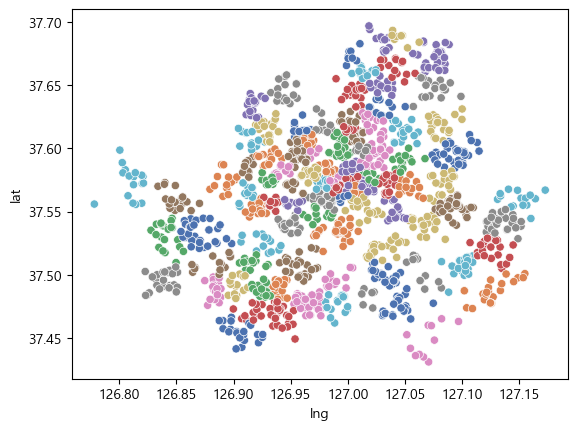

In [22]:
sns.scatterplot(data=seoul_df, x="lng", y="lat", hue="cluster1", legend=False, palette="deep")

<AxesSubplot: xlabel='lng', ylabel='lat'>

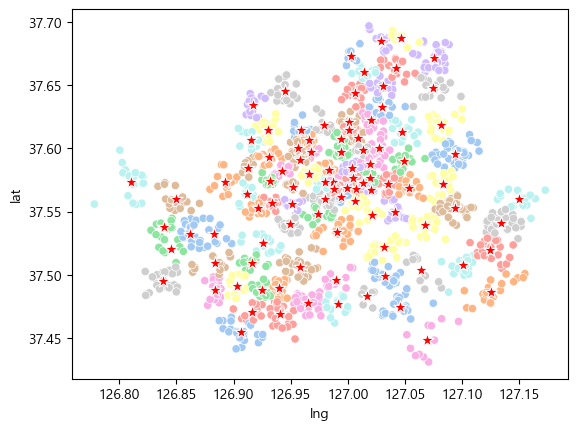

In [23]:
sns.scatterplot(data=seoul_df, x="lng", y="lat", hue="cluster1", legend=False, palette="pastel")
sns.scatterplot(data=seoul_cluster1, x="lng", y="lat", marker="*", c="red", s=100)


>>> maximun distance between centroids and cluster node
max: 3.42503, min:0.35359, average: 1.36312

>>> # of nodes in cluster
max: 41, min: 7, average: 17.96

>>> silhouette of clusters
0.38207


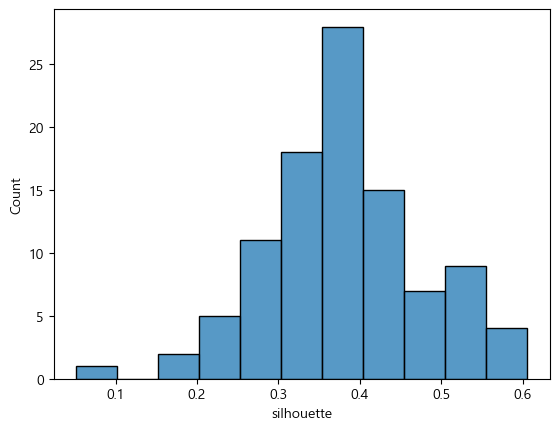

In [24]:
check_cluster_result(seoul_df, "cluster1", seoul_cluster1)

# Clustering tptp

In [28]:
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def elbow(data, s, e, r, path):
    sse = []
    for i in tqdm(range(s, e+1, r)):
        kmeans = KMeans(n_clusters=i, n_init="auto")
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.plot(range(s, e+1, r), sse, 'bo-')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.savefig(f"{path}.png", dpi=1000, bbox_inches="tight")

## Step 1: all

  0%|          | 0/77 [00:00<?, ?it/s]

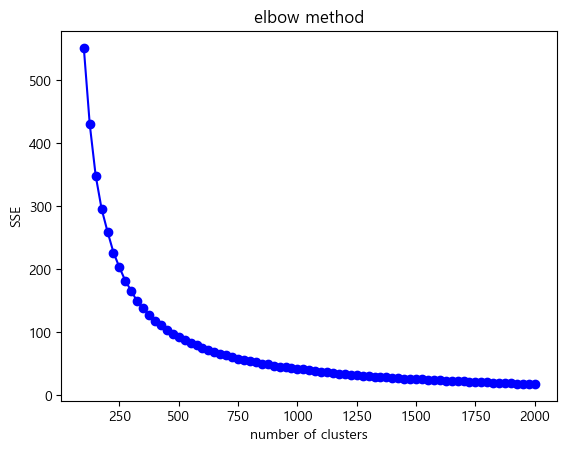

In [30]:
elbow(all_df[["lat", "lng"]], 100, 2000, 25, "230718-for cluster1-1")

  0%|          | 0/26 [00:00<?, ?it/s]

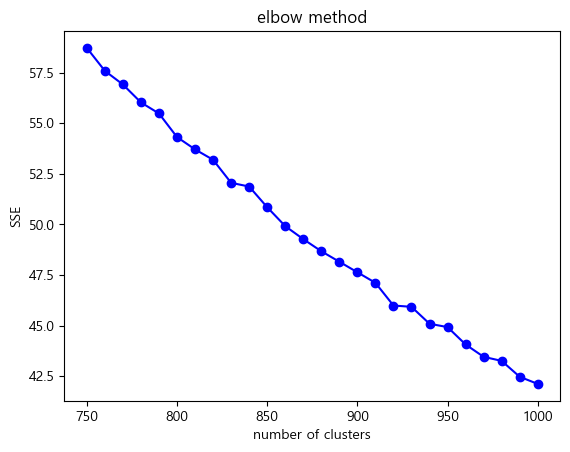

In [32]:
elbow(all_df[["lat", "lng"]], 750, 1000, 10, "230718-for cluster1-2")

In [37]:
kmeans1 = Clustering(k=1000, max_iter=1000)
assignment, centroids = kmeans1.fit(all_df[["lat", "lng"]].to_numpy())

start fitting... 
iterations... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 


>>> maximun distance between centroids and cluster node
max: 90.53680, min:0.92217, average: 6.46350

>>> # of nodes in cluster
max: 120, min: 3, average: 35.402

>>> silhouette of clusters
0.37434


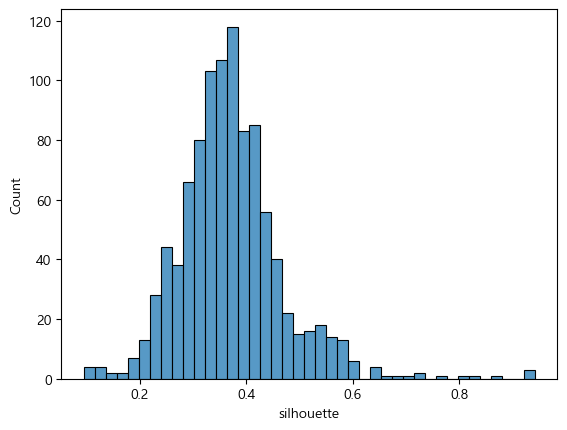

In [38]:
all_cluster_1 = pd.DataFrame(centroids, columns=["lat", "lng"]).reset_index(names="cluster_1")
all_cluster_1["cluster_1"] += 1
all_df["cluster_1"] = np.array(assignment) + 1

check_cluster_result(all_df, "cluster_1", all_cluster_1)

In [39]:
all_df.to_csv("./all_data_230718_1000.csv", index=False, encoding="utf8")

In [23]:
all_df = pd.read_csv("./all_data_230718_1000.csv")
all_cluster_1 = pd.read_csv("./all_cluster_1_230718_1000.csv")
all_cluster_2 = pd.read_csv("./all_cluster_2_230718_200.csv")
all_cluster_3 = pd.read_csv("./all_cluster_3_230718_40.csv")

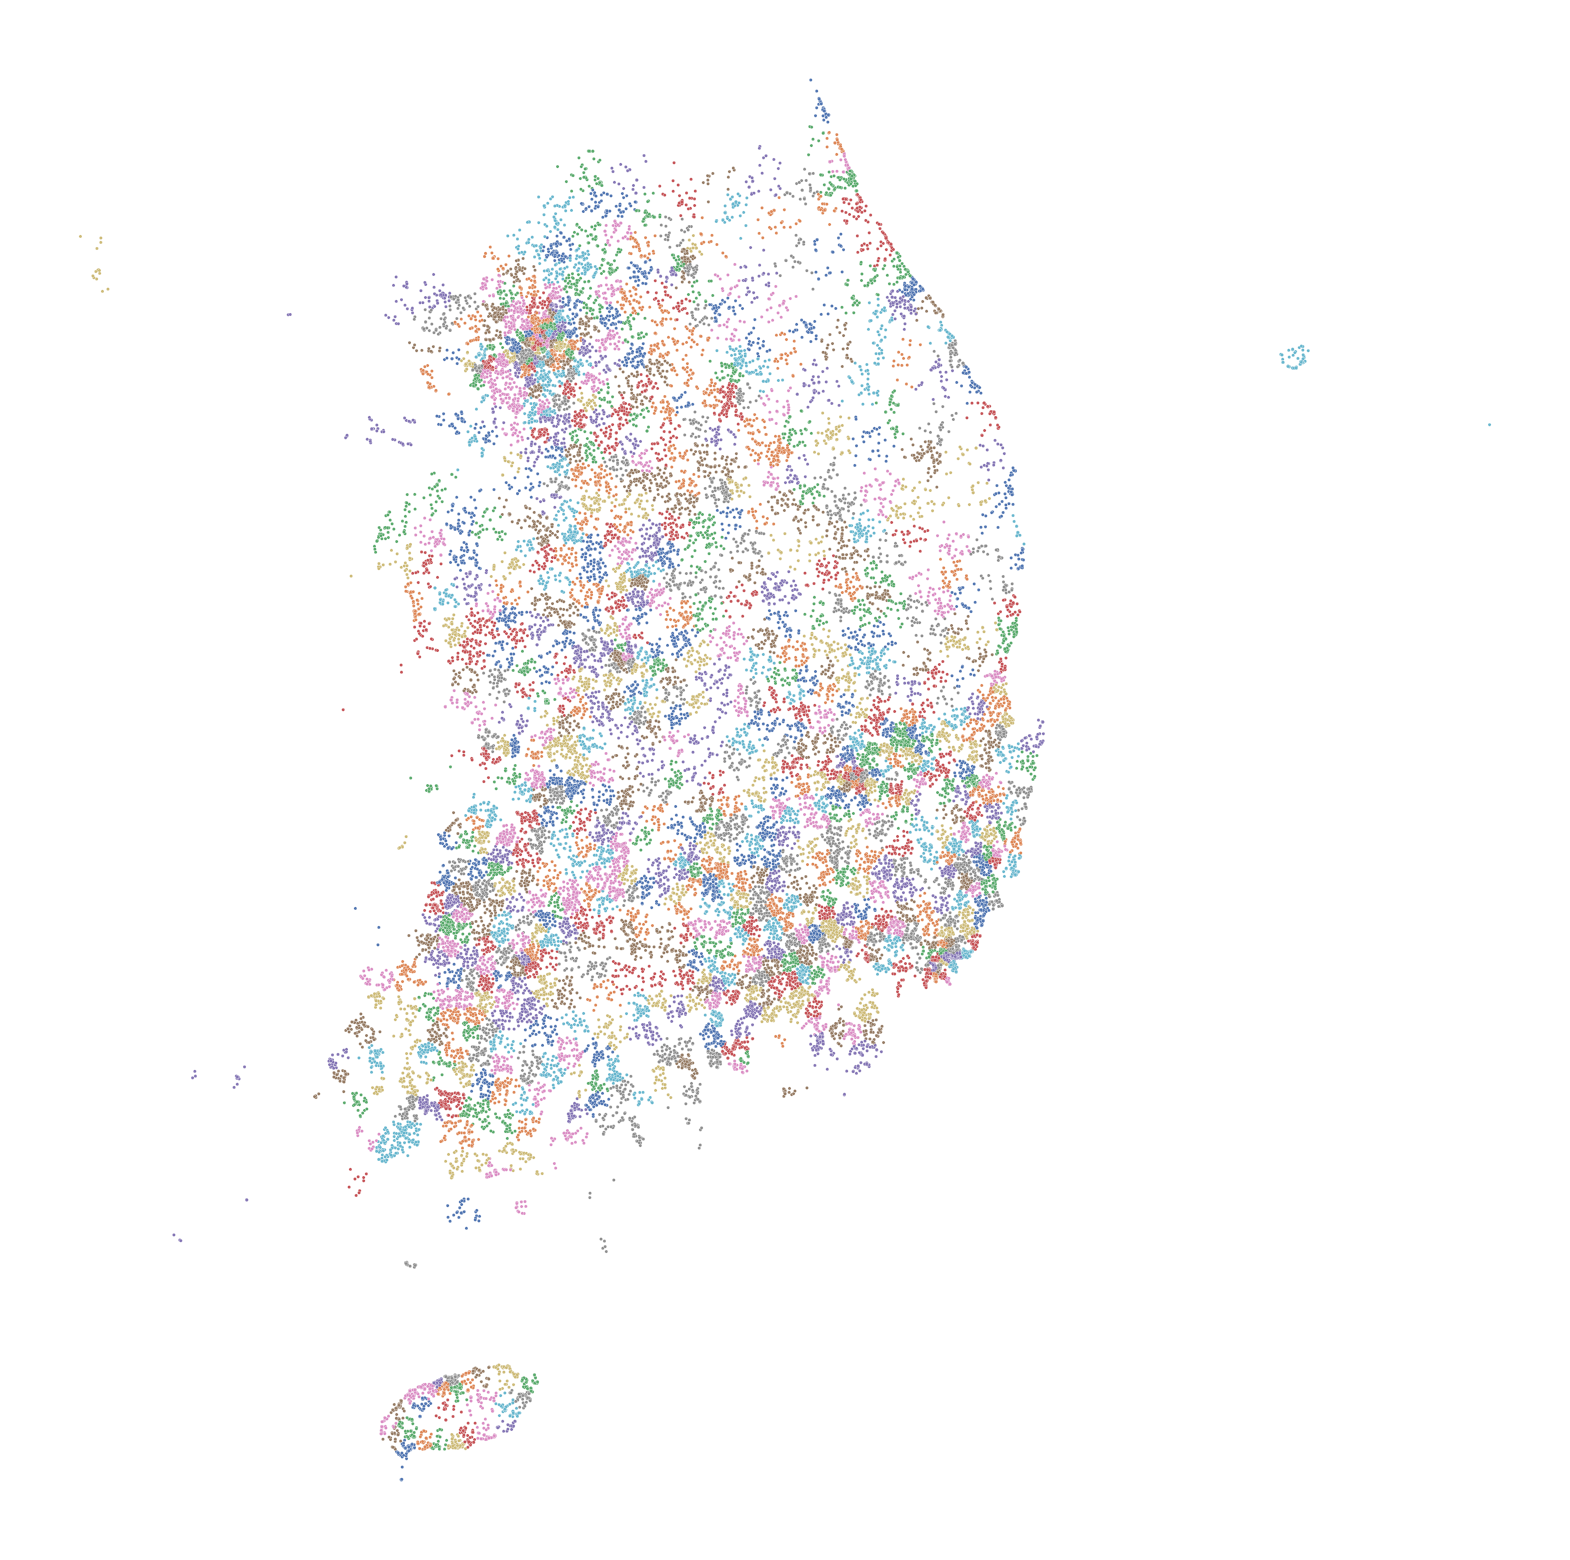

In [25]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=all_df, x="lng", y="lat", hue="cluster_1", legend=False, palette="deep", s=5)
plt.axis("off")
plt.savefig("230724-cluster1-not_centers.png", dpi=750, bbox_inches="tight")

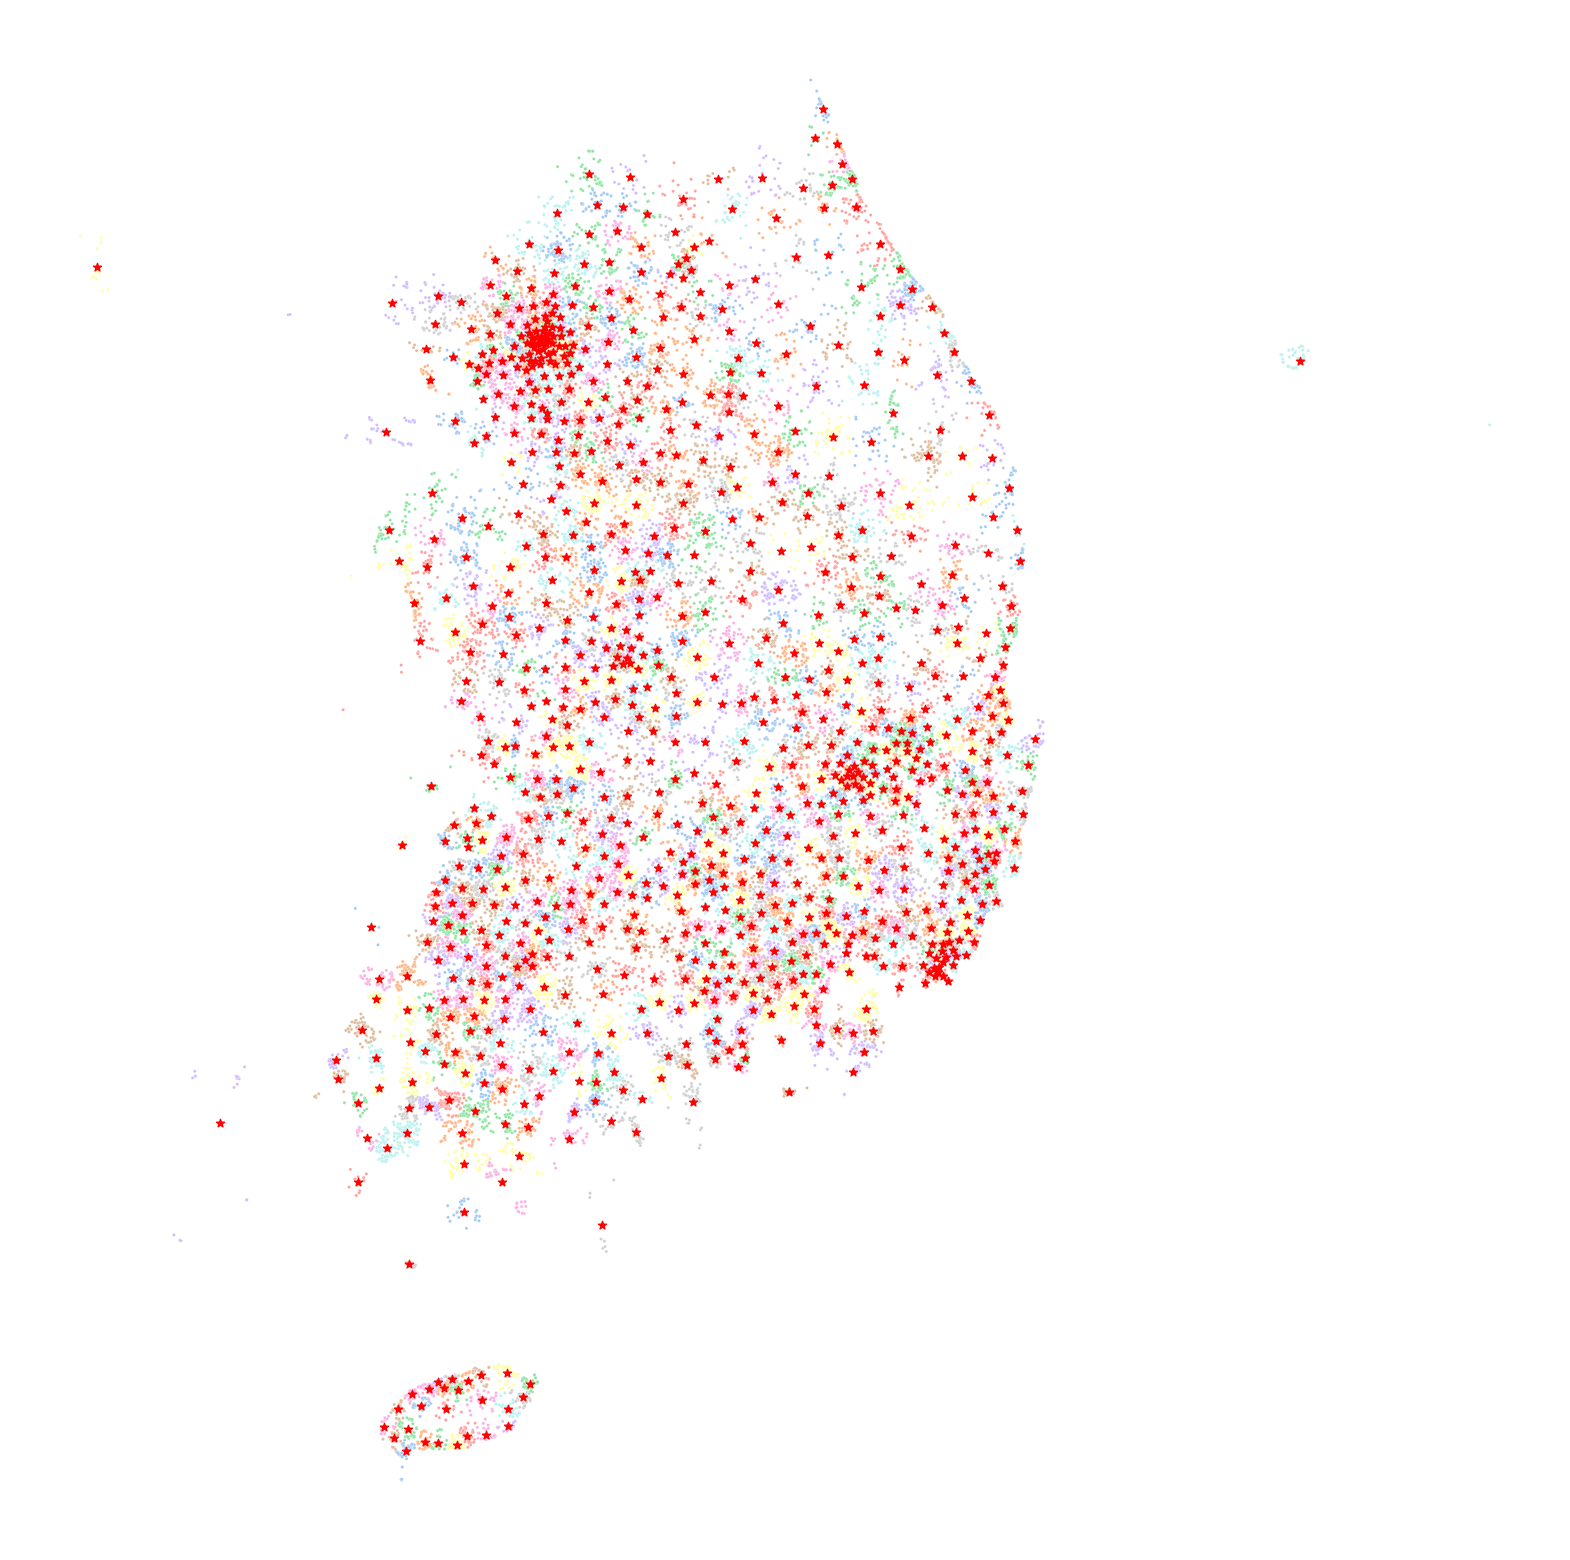

In [27]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=all_df, x="lng", y="lat", hue="cluster_1", legend=False, palette="pastel", s=5)
plt.scatter(all_cluster_1["lng"], all_cluster_1["lat"], marker="*", c="red")
plt.axis("off")
plt.savefig("230724-cluster1.png", dpi=750, bbox_inches="tight")

## Step 2: Cluster_Small

  0%|          | 0/50 [00:00<?, ?it/s]

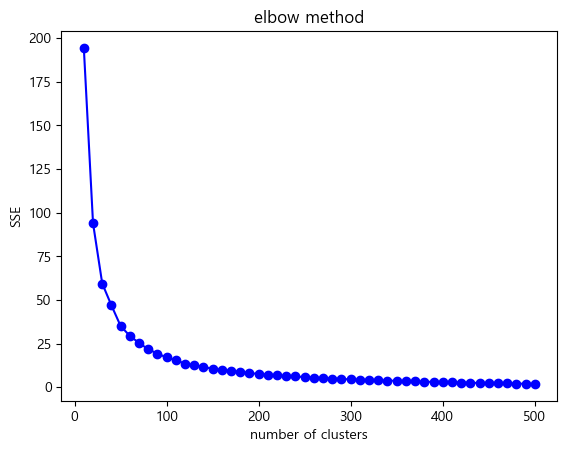

In [45]:
elbow(all_cluster_1[["lat", "lng"]], 10, 500, 10, "230718-for cluster2-1")

In [82]:
kmeans2 = Clustering(k=200, max_iter=1000, init=True)
assignment, centroids = kmeans2.fit(all_cluster_1[["lat", "lng"]].to_numpy())

start fitting... 100 
iterations... 1 2 3 4 5 6 7 8 


>>> maximun distance between centroids and cluster node
max: 38.46804, min:0.00000, average: 11.33417

>>> # of nodes in cluster
max: 26, min: 1, average: 5.0

>>> silhouette of clusters
0.21835


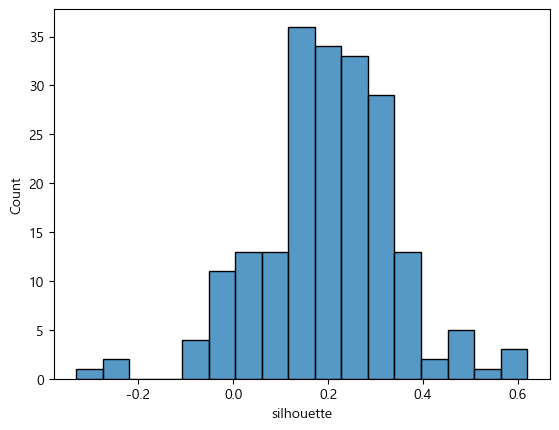

In [83]:
all_cluster_2 = pd.DataFrame(centroids, columns=["lat", "lng"]).reset_index(names="cluster_2")
all_cluster_2["cluster_2"] += 1
all_cluster_1["cluster_2"] = np.array(assignment) + 1

check_cluster_result(all_cluster_1, "cluster_2", all_cluster_2)

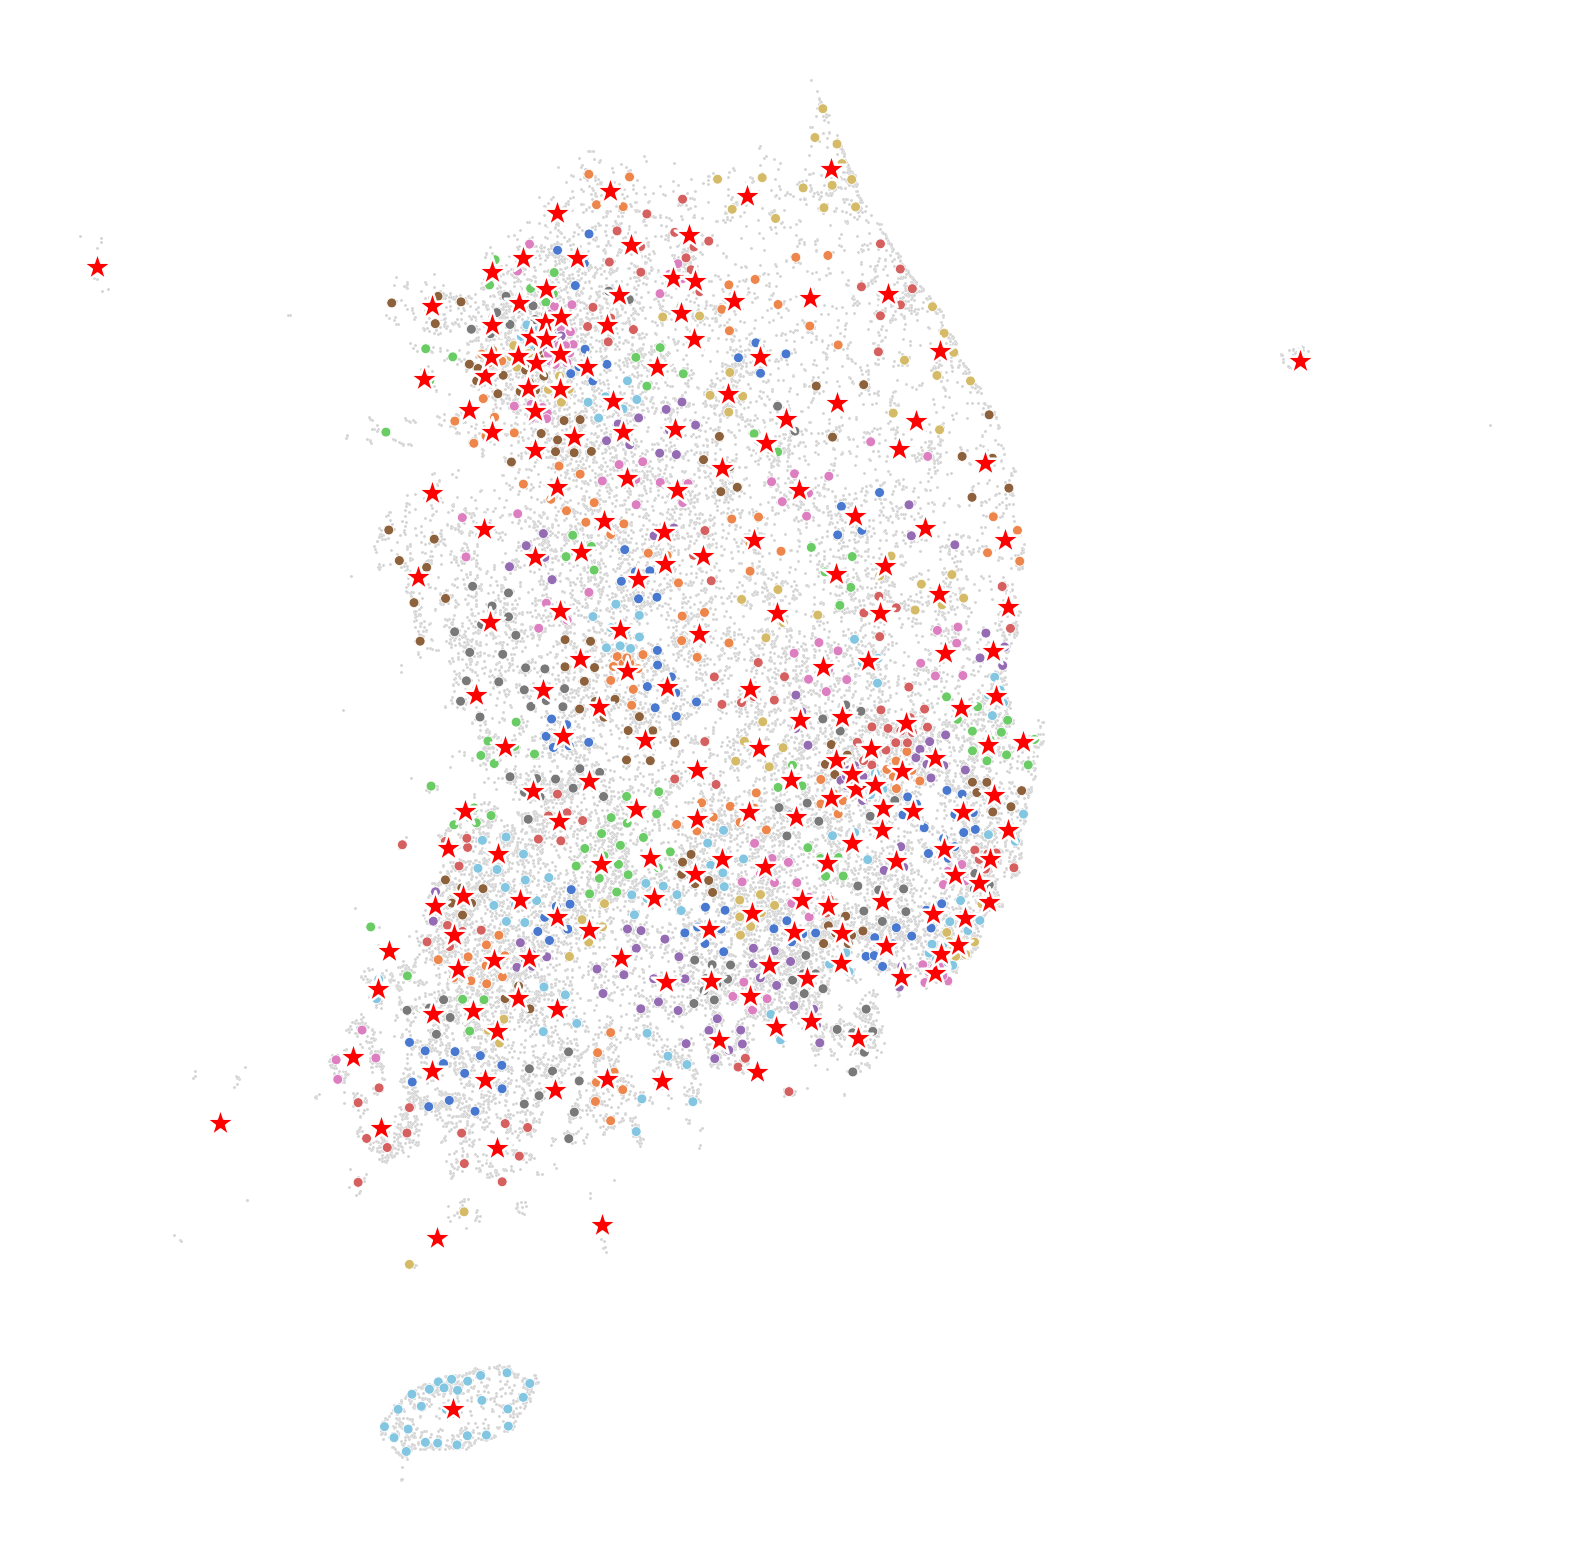

In [28]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=all_df, x="lng", y="lat", legend=False, c="lightgray", s=5)
sns.scatterplot(data=all_cluster_1, x="lng", y="lat", hue="cluster_2", legend=False, palette="muted", s=50)
sns.scatterplot(data=all_cluster_2, x="lng", y="lat", marker="*", c="red", s=500)
plt.axis("off")
plt.savefig("230724-cluster2.png", dpi=750, bbox_inches="tight")

In [88]:
all_cluster_1.to_csv(f"./all_cluster_1_230718_{len(all_cluster_1)}.csv", index=False, encoding="utf8")

## Step 3: Cluster_Medium

  0%|          | 0/20 [00:00<?, ?it/s]

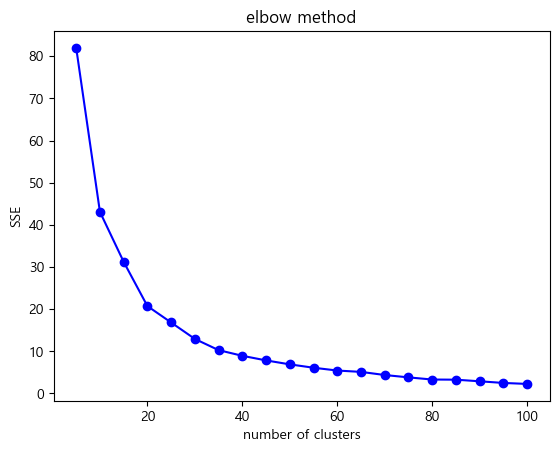

In [58]:
elbow(all_cluster_2[["lat", "lng"]], 5, 100, 5, "230718-for cluster3-1")

In [85]:
kmeans3 = Clustering(k=40, max_iter=1000, init=True)
assignment, centroids = kmeans3.fit(all_cluster_2[["lat", "lng"]].to_numpy())

start fitting... 
iterations... 1 2 3 4 5 6 7 8 


>>> maximun distance between centroids and cluster node
max: 91.78981, min:0.00000, average: 27.29826

>>> # of nodes in cluster
max: 10, min: 1, average: 5.0

>>> silhouette of clusters
0.21106


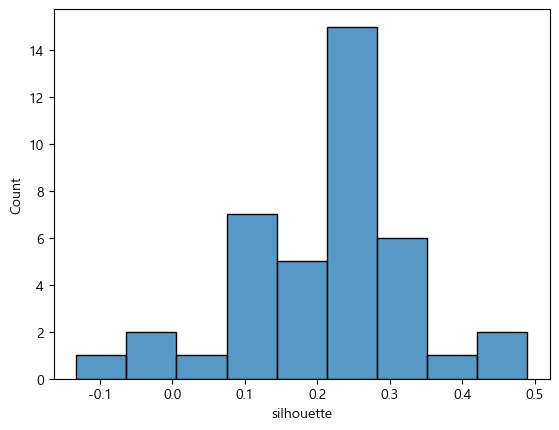

In [86]:
all_cluster_3 = pd.DataFrame(centroids, columns=["lat", "lng"]).reset_index(names="cluster_3")
all_cluster_3["cluster_3"] += 1
all_cluster_2["cluster_3"] = np.array(assignment) + 1

check_cluster_result(all_cluster_2, "cluster_3", all_cluster_3)

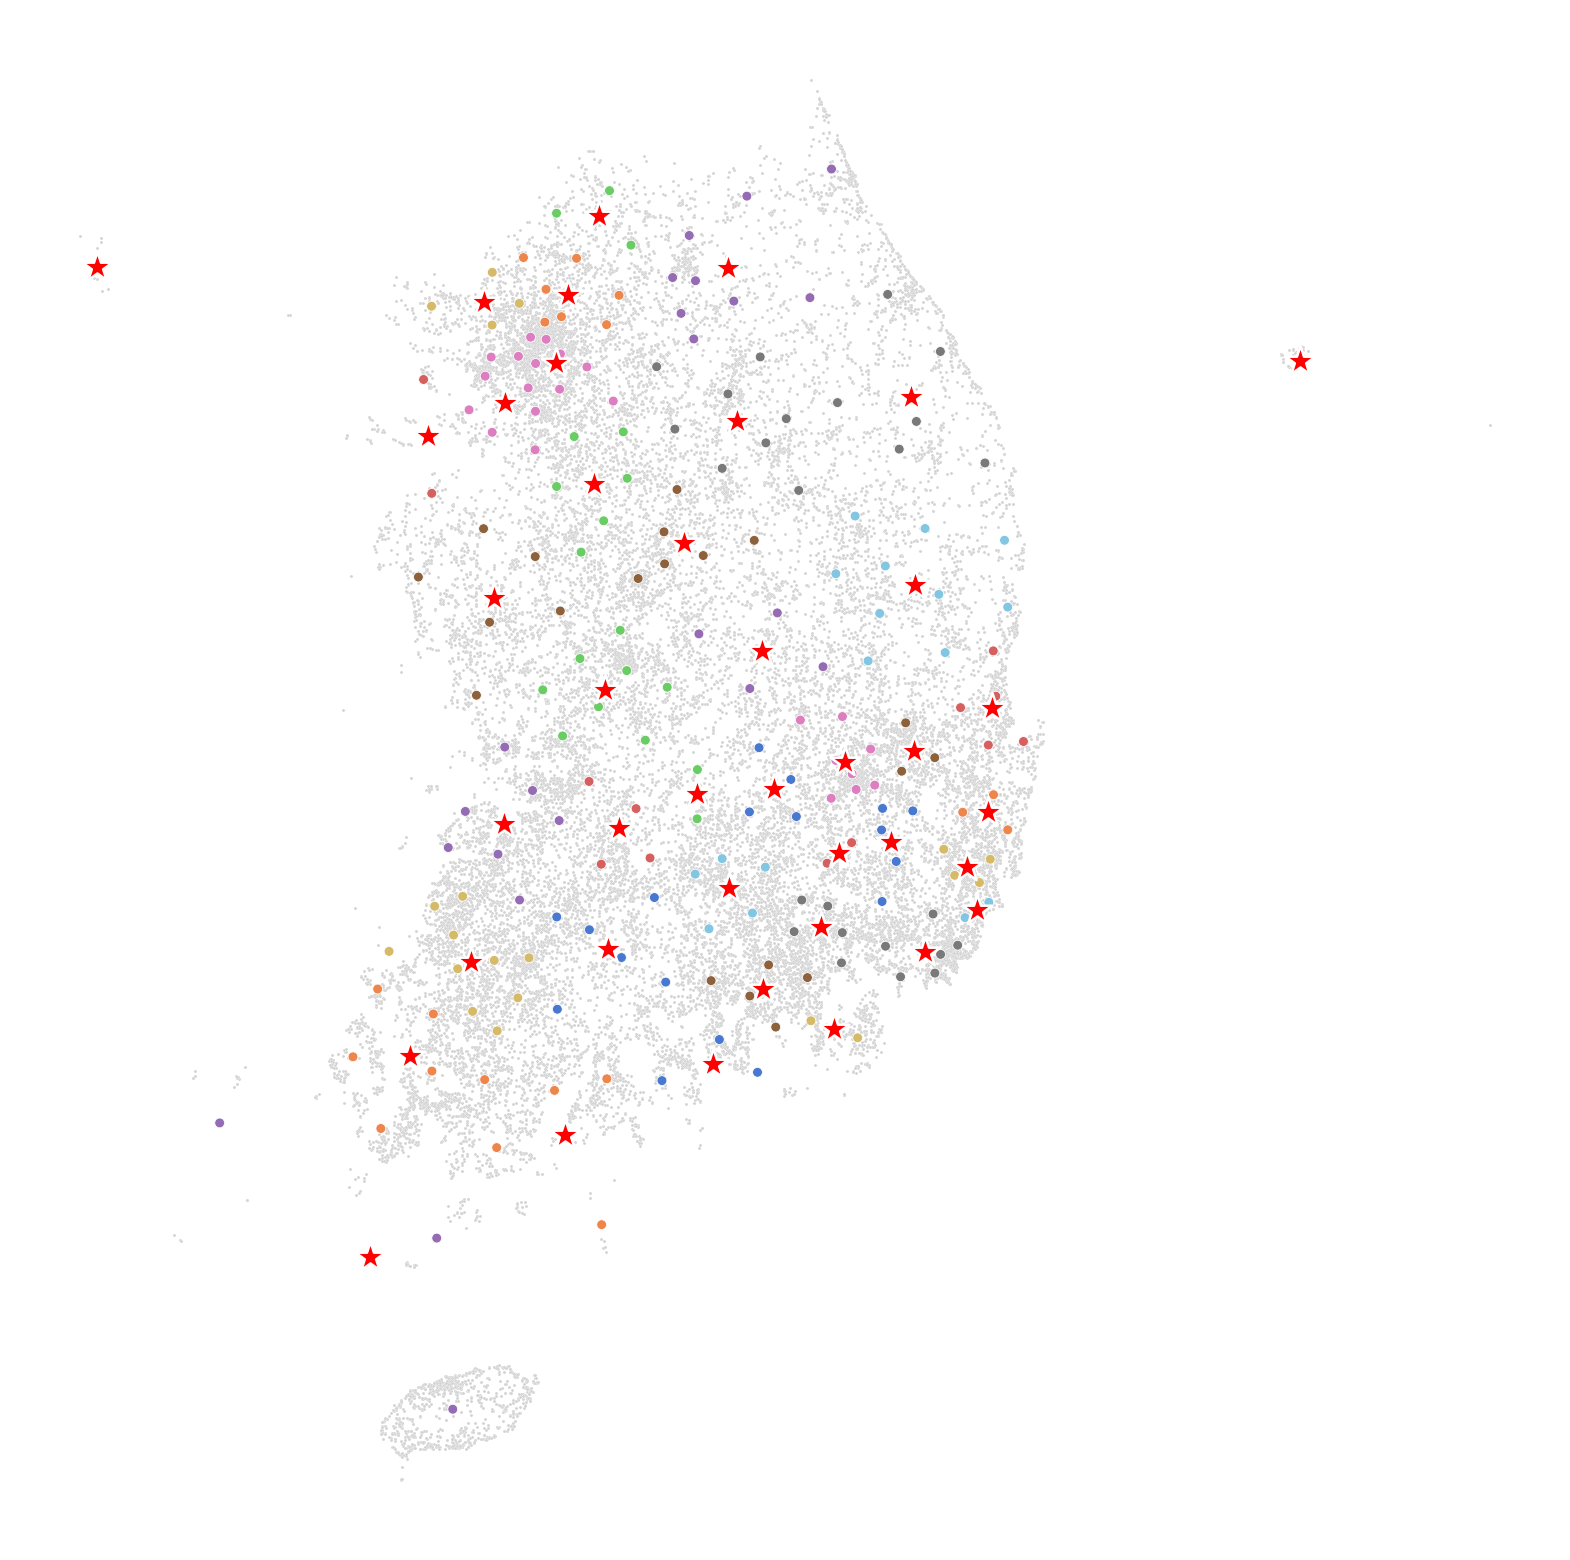

In [29]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=all_df, x="lng", y="lat", legend=False, c="lightgray", s=5)
sns.scatterplot(data=all_cluster_2, x="lng", y="lat", hue="cluster_3", legend=False, palette="muted", s=50)
sns.scatterplot(data=all_cluster_3, x="lng", y="lat", marker="*", c="red", s=500)
plt.axis("off")
plt.savefig("230724-cluster3.png", dpi=750, bbox_inches="tight")

In [89]:
all_cluster_2.to_csv(f"./all_cluster_2_230718_{len(all_cluster_2)}.csv", index=False, encoding="utf8")
all_cluster_3.to_csv(f"./all_cluster_3_230718_{len(all_cluster_3)}.csv", index=False, encoding="utf8")

## Step 4: Calculate Max Distance With-In Cluster

In [1]:
import pandas as pd

all_data = pd.read_csv("./all_data_230718_1000.csv")
all_data = all_data[["lat", "lng", "cluster_1"]]
all_data.columns = ["lat", "lng", "cluster_s"]

all_cluster_1 = pd.read_csv("./all_cluster_1_230718_1000.csv")
all_cluster_1.columns = ["cluster_s", "lat_center_s", "lng_center_s", "cluster_m"]

all_cluster_2 = pd.read_csv("./all_cluster_2_230718_200.csv")
all_cluster_2.columns = ["cluster_m", "lat_center_m", "lng_center_m", "cluster_l"]

all_cluster_3 = pd.read_csv("./all_cluster_3_230718_40.csv")
all_cluster_3.columns = ["cluster_l", "lat_center_l", "lng_center_l"]

In [2]:
temp = pd.merge(
    left=pd.merge(
        left=pd.merge(
            left=all_cluster_3, 
            right=all_cluster_2, 
            on="cluster_l"
        ),
        right=all_cluster_1,
        on="cluster_m"
    ),
    right=all_data,
    on="cluster_s"
)

temp.head()

cluster_l  lat_center_l  lng_center_l  cluster_m  lat_center_m  \
0          1     35.815524    128.185342         93     35.852315   
1          1     35.815524    128.185342         93     35.852315   
2          1     35.815524    128.185342         93     35.852315   
3          1     35.815524    128.185342         93     35.852315   
4          1     35.815524    128.185342         93     35.852315   

   lng_center_m  cluster_s  lat_center_s  lng_center_s        lat         lng  
0    128.272509         92     35.827394    128.329809  35.827073  128.305938  
1    128.272509         92     35.827394    128.329809  35.862206  128.362137  
2    128.272509         92     35.827394    128.329809  35.804415  128.343823  
3    128.272509         92     35.827394    128.329809  35.810597  128.330544  
4    128.272509         92     35.827394    128.329809  35.786774  128.299425

In [15]:
from tqdm.notebook import tqdm

cluster_l_distance = [[] for _ in range(len(all_cluster_3))]
cluster_m_distance = [[] for _ in range(len(all_cluster_2))]
cluster_s_distance = [[] for _ in range(len(all_cluster_1))]

for i in tqdm(range(len(temp))):
    row = temp.iloc[i, :]
    
    cluster_l, cluster_m, cluster_s = int(row["cluster_l"]) - 1, int(row["cluster_m"]) - 1, int(row["cluster_s"]) - 1
    
    lat, lng = row["lat"], row["lng"]
    
    dist_l = calculate_distance((lat, lng), (row["lat_center_l"], row["lng_center_l"]))
    dist_m = calculate_distance((lat, lng), (row["lat_center_m"], row["lng_center_m"]))
    dist_s = calculate_distance((lat, lng), (row["lat_center_s"], row["lng_center_s"]))
    
    cluster_l_distance[cluster_l].append(dist_l)
    cluster_m_distance[cluster_m].append(dist_m)
    cluster_s_distance[cluster_s].append(dist_s)
    
#     if cluster_l_distance[cluster_l] < dist_l:
#         cluster_l_distance[cluster_l] = dist_l
#     if cluster_m_distance[cluster_m] < dist_m:
#         cluster_m_distance[cluster_m] = dist_m
#     if cluster_s_distance[cluster_s] < dist_s:
#         cluster_s_distance[cluster_s] = dist_s

  0%|          | 0/35402 [00:00<?, ?it/s]

In [42]:
import numpy as np

all_cluster_3["dist"] = [np.mean(x) for x in cluster_l_distance]
all_cluster_2["dist"] = [np.mean(x) for x in cluster_m_distance]
all_cluster_1["dist"] = [np.mean(x) for x in cluster_s_distance]

In [43]:
all_cluster_3["cluster_l"] = all_cluster_3["cluster_l"].apply(lambda x: f"cluster_large_{str(x).zfill(2)}")
all_cluster_2["cluster_l"] = all_cluster_2["cluster_l"].apply(lambda x: f"cluster_large_{str(x).zfill(2)}")
all_cluster_2["cluster_m"] = all_cluster_2["cluster_m"].apply(lambda x: f"cluster_medium_{str(x).zfill(3)}")
all_cluster_1["cluster_m"] = all_cluster_1["cluster_m"].apply(lambda x: f"cluster_medium_{str(x).zfill(3)}")
all_cluster_1["cluster_s"] = all_cluster_1["cluster_s"].apply(lambda x: f"cluster_small_{str(x).zfill(4)}")
all_data["cluster_s"] = all_data["cluster_s"].apply(lambda x: f"cluster_small_{str(x).zfill(4)}")

In [44]:
all_data.to_csv("./final_all_data_230718.csv", index=False, encoding="utf-8")
all_cluster_1.to_csv("./final_all_cluster1_230718.csv", index=False, encoding="utf-8")
all_cluster_2.to_csv("./final_all_cluster2_230718.csv", index=False, encoding="utf-8")
all_cluster_3.to_csv("./final_all_cluster3_230718.csv", index=False, encoding="utf-8")

## Step 5: Update DB

In [287]:
import pandas as pd
import pymysql

In [288]:
all_data = pd.read_csv("./final_all_data_230718.csv")
all_cluster_1 = pd.read_csv("./final_all_cluster1_230718.csv")
all_cluster_2 = pd.read_csv("./final_all_cluster2_230718.csv")
all_cluster_3 = pd.read_csv("./final_all_cluster3_230718.csv")

In [3]:
connect = pymysql.connect(
    host='192.168.0.132', 
    user='newdealadmin', 
    password='newdealtptp',
    db='newdealdb', 
    charset='utf8'
)
 
# connect = pymysql.connect(
#     host='localhost', 
#     user='root', 
#     password='1234',
#     db='newdealdb', 
#     charset='utf8'
# )
 
    
cursor = connect.cursor()

sql = "SELECT id, category_id, lat, lng, region FROM tptp"
cursor.execute(sql)
 
rows = cursor.fetchall()

print(len(rows))

35402


In [49]:
sql = """
CREATE TABLE IF NOT EXISTS cluster_l (
	cluster_l_id VARCHAR(20) PRIMARY KEY,
    lat_center DOUBLE NOT NULL,
    lng_center DOUBLE NOT NULL,
    dist DOUBLE NOT NULL
) ENGINE=InnoDB DEFAULT CHARSET=utf8;
"""

cursor.execute(sql)

0

In [50]:
sql = """
CREATE TABLE IF NOT EXISTS cluster_m (
    cluster_m_id VARCHAR(20) PRIMARY KEY,
    lat_center DOUBLE NOT NULL,
    lng_center DOUBLE NOT NULL,
    dist DOUBLE NOT NULL,
    cluster_l_id VARCHAR(20) NOT NULL,
    CONSTRAINT fk_cluster_l FOREIGN KEY (cluster_l_id)
    REFERENCES cluster_l(cluster_l_id)
) ENGINE=InnoDB DEFAULT CHARSET=utf8;
"""

cursor.execute(sql)

0

In [ ]:
sql = """
ALTER TABLE cluster_s
RENAME COLUMN cluster_id TO cluster_s_id,
RENAME COLUMN center_lat TO lat_center,
RENAME COLUMN center_lng TO lng_center,
ADD dist DOUBLE NOT NULL,
ADD cluster_m_id VARCHAR(20) NOT NULL,
ADD CONSTRAINT fk_cluster_m FOREIGN KEY (cluster_m_id) REFERENCES cluster_m(cluster_m_id)
"""

cursor.execute(sql)

In [61]:
sql = """
ALTER TABLE tptp
RENAME COLUMN cluster_id TO cluster_s_id;
"""
cursor.execute(sql)

0

In [62]:
connect.commit()

In [63]:
data = [(
    all_cluster_3.loc[i, "cluster_l"], 
    all_cluster_3.loc[i, "lat_center_l"], 
    all_cluster_3.loc[i, "lng_center_l"],
    all_cluster_3.loc[i, "dist"]
) for i in range(len(all_cluster_3))]

sql = """
INSERT IGNORE INTO cluster_l 
VALUES (%s, %s, %s, %s)
"""

cursor.executemany(sql, data)

connect.commit()

In [64]:
data = [(
    all_cluster_2.loc[i, "cluster_m"], 
    all_cluster_2.loc[i, "lat_center_m"], 
    all_cluster_2.loc[i, "lng_center_m"],
    all_cluster_2.loc[i, "dist"],
    all_cluster_2.loc[i, "cluster_l"]
) for i in range(len(all_cluster_2))]

sql = """
INSERT IGNORE INTO cluster_m 
VALUES (%s, %s, %s, %s, %s)
"""

cursor.executemany(sql, data)

connect.commit()

In [65]:
data = [(
    all_cluster_1.loc[i, "cluster_s"], 
    all_cluster_1.loc[i, "lat_center_s"], 
    all_cluster_1.loc[i, "lng_center_s"],
    all_cluster_1.loc[i, "dist"],
    all_cluster_1.loc[i, "cluster_m"]
) for i in range(len(all_cluster_1))]

sql = """
INSERT IGNORE INTO cluster_s 
VALUES (%s, %s, %s, %s, %s)
"""

cursor.executemany(sql, data)

connect.commit()

In [66]:
sql = """
SELECT `id`, lat, lng
FROM tptp t;
"""

cursor.execute(sql)
rows = cursor.fetchall()
len(rows)

35402

In [67]:
temp = pd.DataFrame(rows, columns=["id", "lat", "lng"])

all_tptp = pd.merge(left=all_data, right=temp, on=["lat", "lng"], how="right")
len(all_tptp)

35658

In [68]:
data = [(
    all_tptp.loc[i, "cluster_s"], 
    all_tptp.loc[i, "id"]
) for i in range(len(all_tptp))]

sql = """
UPDATE tptp 
SET cluster_s_id=%s 
WHERE id=%s;
"""

cursor.executemany(sql, data)

connect.commit()

## Step 6: get clusters near a point

In [99]:
sql = """
SELECT lat, lng
FROM tptp t
"""

cursor.execute(sql)
rows = cursor.fetchall()
all_tptp = pd.DataFrame(rows, columns=["lat", "lng"])
all_tptp.head(2)


sql = """
SELECT lat, lng
FROM tptp t
WHERE region = "서울특별시"
"""

cursor.execute(sql)
rows = cursor.fetchall()
seoul = pd.DataFrame(rows, columns=["lat", "lng"])
seoul.head(2)

lat         lng
0  37.570176  127.019391
1  37.546257  126.981723

In [142]:
sql = """
SELECT AVG(dist)
FROM cluster_l
"""
cursor.execute(sql)
dist_l_avg = cursor.fetchone()[0]

sql = """
SELECT AVG(dist)
FROM cluster_m
"""
cursor.execute(sql)
dist_m_avg = cursor.fetchone()[0]

sql = """
SELECT AVG(dist)
FROM cluster_s
"""
cursor.execute(sql)
dist_s_avg = cursor.fetchone()[0]

ratio_l = dist_l_avg / dist_s_avg / 2
ratio_m = dist_m_avg / dist_s_avg / 2

print(ratio_l, ratio_m)

3.3119244649467006 1.3696969712585179


In [143]:
geoLat = 37.566826
geoLng = 126.9786567
criterion = 5

In [144]:
sql = """
SELECT *
FROM cluster_l
"""

cursor.execute(sql)
rows = cursor.fetchall()

cluster_l = pd.DataFrame(rows, columns=["l_id", "lat", "lng", "dist"])

cluster_l_list = []

for l_id, lat, lng, dist in rows:
    if abs(calculate_distance((lat, lng), (geoLat, geoLng)) - dist) < criterion * ratio_l:
        cluster_l_list.append(l_id)
print(len(cluster_l_list))

4


In [159]:
data = ','.join(['%s'] * len(cluster_l_list))

sql = f"""
SELECT m.cluster_m_id, m.lat_center, m.lng_center, m.cluster_l_id
FROM cluster_m m
WHERE m.cluster_l_id IN ({data})
"""
cursor.execute(sql, cluster_l_list)
rows = cursor.fetchall()

cluster_m = pd.DataFrame(rows, columns=["m_id", "lat", "lng", "l_id"])


sql = f"""
SELECT t.lat, t.lng
FROM cluster_m m
JOIN cluster_s s
ON m.cluster_m_id = s.cluster_m_id
JOIN tptp t
ON s.cluster_s_id = t.cluster_s_id
WHERE m.cluster_l_id IN ({data})
"""

cursor.execute(sql, cluster_l_list)
rows = cursor.fetchall()

cluster_m_map = pd.DataFrame(rows, columns=["lat", "lng"])

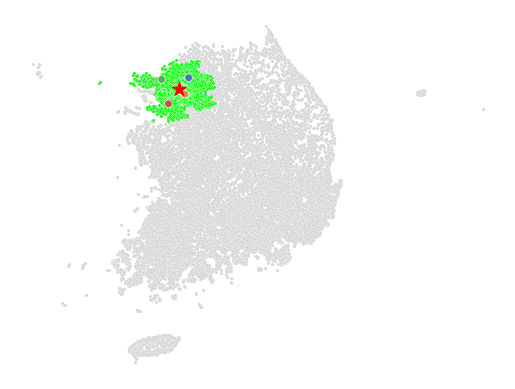

In [160]:
sns.scatterplot(data=all_tptp, x="lng", y="lat", legend=False, c="lightgray", s=5)
sns.scatterplot(data=cluster_m_map, x="lng", y="lat", legend=False, c="lime", s=5)
sns.scatterplot(data=cluster_l[cluster_l["l_id"].isin(cluster_l_list)], x="lng", y="lat", hue="l_id", legend=False, palette="deep", s=30)
plt.scatter(x=geoLng, y=geoLat, marker="*", c="red", s=100)
plt.axis("off")
plt.savefig("./230724-how to get cluster-large.png", dpi=750, bbox_inches="tight")

In [147]:
data = ','.join(['%s'] * len(cluster_l_list))

sql = f"""
SELECT *
FROM cluster_m
WHERE cluster_l_id IN ({data})
"""

cursor.execute(sql, cluster_l_list)
rows = cursor.fetchall()
print(len(rows))

cluster_m_list = []

for m_id, lat, lng, dist, l_id in rows:
    if abs(calculate_distance((lat, lng), (geoLat, geoLng)) - dist) < criterion * ratio_m:
        cluster_m_list.append(m_id)
print(len(cluster_m_list))

26
5


In [148]:
data = ','.join(['%s'] * len(cluster_m_list))

sql = f"""
SELECT *
FROM cluster_s
WHERE cluster_m_id IN ({data})
"""

cursor.execute(sql, cluster_m_list)
rows = cursor.fetchall()

cluster_s = pd.DataFrame(rows, columns=["s_id", "lat", "lng", "dist", "m_id"])

sql = f"""
SELECT t.lat, t.lng
FROM cluster_s s
JOIN tptp t
ON s.cluster_s_id = t.cluster_s_id
WHERE s.cluster_m_id IN ({data}) AND t.region = "서울특별시"
"""

cursor.execute(sql, cluster_m_list)
rows = cursor.fetchall()

cluster_s_map = pd.DataFrame(rows, columns=["lat", "lng"])

In [149]:
cluster_s = cluster_s[
    (cluster_s["lat"] <= max(seoul["lat"])) & 
    (cluster_s["lat"] >= min(seoul["lat"])) & 
    (cluster_s["lng"] <= max(seoul["lng"])) & 
    (cluster_s["lng"] >= min(seoul["lng"]))
]

cluster_s_map = cluster_s_map[
    (cluster_s_map["lat"] <= max(seoul["lat"])) & 
    (cluster_s_map["lat"] >= min(seoul["lat"])) & 
    (cluster_s_map["lng"] <= max(seoul["lng"])) & 
    (cluster_s_map["lng"] >= min(seoul["lng"]))
]

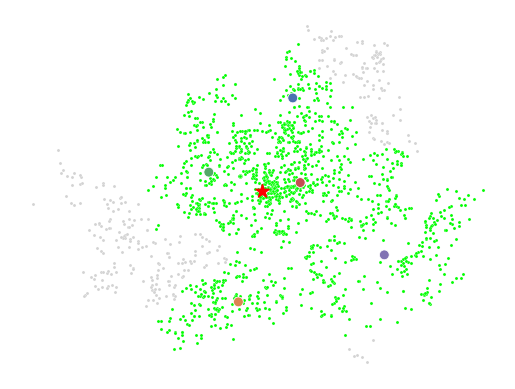

In [151]:
sns.scatterplot(data=seoul, x="lng", y="lat", legend=False, c="lightgray", s=5)
sns.scatterplot(data=cluster_s_map, x="lng", y="lat", legend=False, c="lime", s=5)
sns.scatterplot(data=cluster_m[cluster_m["m_id"].isin(cluster_m_list)], x="lng", y="lat", hue="m_id", legend=False, palette="deep", s=50)
plt.scatter(x=geoLng, y=geoLat, marker="*", c="red", s=100)
plt.axis("off")
plt.savefig("./230724-how to get cluster-medium.png", dpi=750, bbox_inches="tight")

In [152]:
data = ','.join(['%s'] * len(cluster_m_list))

sql = f"""
SELECT *
FROM cluster_s
WHERE cluster_m_id IN ({data})
"""

cursor.execute(sql, cluster_m_list)
rows = cursor.fetchall()
print(len(rows))

cluster_s_list = []

for s_id, lat, lng, dist, m_id in rows:
#     print(calculate_distance((lat, lng), (geoLat, geoLng)), abs(dist - criterion))
    if abs(calculate_distance((lat, lng), (geoLat, geoLng)) - dist) < criterion:
        cluster_s_list.append(s_id)
print(len(cluster_s_list))

46
20


In [153]:
data = ','.join(['%s'] * len(cluster_s_list))

sql = f"""
SELECT lat, lng, cluster_s_id
FROM tptp
WHERE cluster_s_id IN ({data})
"""

cursor.execute(sql, cluster_s_list)
rows = cursor.fetchall()
seoul_df = pd.DataFrame(rows, columns=["lat", "lng", "s_id"])


sql = f"""
SELECT t.lat, t.lng
FROM tptp t
WHERE t.cluster_s_id IN ({data}) 
"""

cursor.execute(sql, cluster_s_list)
rows = cursor.fetchall()

tptp_map = pd.DataFrame(rows, columns=["lat", "lng"])

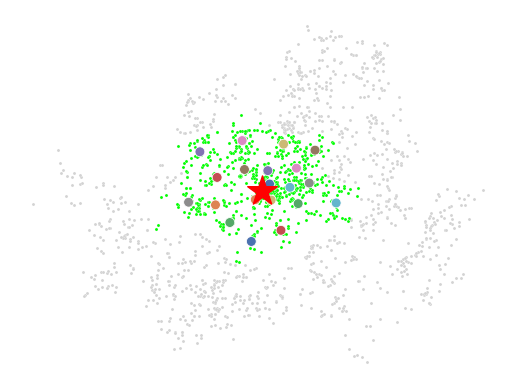

In [156]:
sns.scatterplot(data=seoul, x="lng", y="lat", legend=False, c="lightgray", s=5)
sns.scatterplot(data=tptp_map, x="lng", y="lat", legend=False, c="lime", s=5)
sns.scatterplot(data=cluster_s[cluster_s["s_id"].isin(cluster_s_list)], x="lng", y="lat", hue="s_id", legend=False, palette="deep", s=50)
plt.scatter(x=geoLng, y=geoLat, marker="*", c="red", s=500)
plt.axis("off")
plt.savefig("./230724-how to get cluster-small.png", dpi=750, bbox_inches="tight")

In [31]:
len(seoul_df[seoul_df["s_id"].isin(cluster_s_list)])

744

In [35]:
data = ','.join(['%s'] * len(cluster_m_list))

sql = f"""
SELECT *
FROM cluster_s
WHERE cluster_m_id IN ({data})
"""

cursor.execute(sql, cluster_m_list)
rows = cursor.fetchall()

cluster_s = pd.DataFrame(rows, columns=["s_id", "lat", "lng", "dist", "m_id"])

sql = f"""
SELECT t.lat, t.lng
FROM cluster_s s
JOIN tptp t
ON s.cluster_s_id = t.cluster_s_id
WHERE s.cluster_m_id IN ({data}) 
"""

cursor.execute(sql, cluster_m_list)
rows = cursor.fetchall()

cluster_s_map = pd.DataFrame(rows, columns=["lat", "lng"])

In [37]:
cluster_s = cluster_s[
    (cluster_s["lat"] <= max(seoul["lat"])) & 
    (cluster_s["lat"] >= min(seoul["lat"])) & 
    (cluster_s["lng"] <= max(seoul["lng"])) & 
    (cluster_s["lng"] >= min(seoul["lng"]))
]

cluster_s_map = cluster_s_map[
    (cluster_s_map["lat"] <= max(seoul["lat"])) & 
    (cluster_s_map["lat"] >= min(seoul["lat"])) & 
    (cluster_s_map["lng"] <= max(seoul["lng"])) & 
    (cluster_s_map["lng"] >= min(seoul["lng"]))
]

In [39]:
cluster_m

m_id        lat         lng              l_id
0   cluster_medium_021  37.889666  127.169149  cluster_large_22
1   cluster_medium_073  37.768564  127.011909  cluster_large_22
2   cluster_medium_078  37.640251  127.005958  cluster_large_22
3   cluster_medium_087  37.892555  126.895868  cluster_large_22
4   cluster_medium_088  37.745076  127.387902  cluster_large_22
5   cluster_medium_094  37.630356  127.323784  cluster_large_22
6   cluster_medium_137  37.661386  127.091339  cluster_large_22
7   cluster_medium_026  37.478638  126.958356  cluster_large_27
8   cluster_medium_050  37.331643  127.358105  cluster_large_27
9   cluster_medium_059  37.378007  127.081920  cluster_large_27
10  cluster_medium_070  37.581446  126.932474  cluster_large_27
11  cluster_medium_129  37.506618  126.869923  cluster_large_27
12  cluster_medium_131  37.465027  127.222603  cluster_large_27
13  cluster_medium_145  37.573201  127.012523  cluster_large_27
14  cluster_medium_177  37.515923  127.086133  cluster_large_27
15  cluster_medium_016  37.702505  126.422446  cluster_large_29
16  cluster_medium_028  37.628917  126.734393  cluster_large_29
17  cluster_medium_108  37.713573  126.874204  cluster_large_29
18  cluster_medium_173  37.834844  126.735425  cluster_large_29
19  cluster_medium_036  37.428981  126.698590  cluster_large_37
20  cluster_medium_076  37.141178  126.955868  cluster_large_37
21  cluster_medium_092  37.297337  126.615716  cluster_large_37
22  cluster_medium_147  37.291637  126.957662  cluster_large_37
23  cluster_medium_162  37.209517  126.734699  cluster_large_37
24  cluster_medium_176  37.383141  126.920276  cluster_large_37
25  cluster_medium_182  37.503595  126.729577  cluster_large_37

In [62]:
cluster_m[cluster_m["m_id"].isin(cluster_m_list)].index

Int64Index([2, 6, 7, 10, 11, 13, 14, 17], dtype='int64')

In [ ]:
cluster_m.loc[2, "m_id"]

In [80]:
from matplotlib.patches import Circle

In [89]:
temp.index

Int64Index([17, 18, 19, 20, 21], dtype='int64')

(126.75839914000001, 127.19266726, 37.416742270888996, 37.7277078513311)

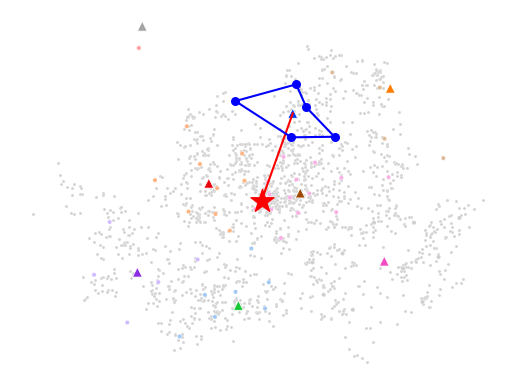

In [98]:
sns.scatterplot(data=seoul, x="lng", y="lat", legend=False, c="lightgray", s=5)
# sns.scatterplot(data=cluster_s_map, x="lng", y="lat", legend=False, c="gray", s=5)
sns.scatterplot(data=cluster_s[cluster_s["m_id"].isin(cluster_m_list)], x="lng", y="lat", hue="m_id", legend=False, palette="pastel", s=10)
sns.scatterplot(data=cluster_m[cluster_m["m_id"].isin(cluster_m_list)], x="lng", y="lat", hue="m_id", legend=False, marker="^", palette="bright", s=50)

temp = cluster_s[cluster_s["m_id"]==cluster_m.loc[2, "m_id"]]
plt.plot([geoLng, cluster_m.loc[2, "lng"]],[geoLat, cluster_m.loc[2, "lat"]], color="red")
plt.scatter(x=temp["lng"], y=temp["lat"], s=30, color="blue")

plt.plot([temp.loc[17, "lng"], temp.loc[19, "lng"]], [temp.loc[17, "lat"], temp.loc[19, "lat"]], color="blue")
plt.plot([temp.loc[17, "lng"], temp.loc[21, "lng"]], [temp.loc[17, "lat"], temp.loc[21, "lat"]], color="blue")
plt.plot([temp.loc[18, "lng"], temp.loc[21, "lng"]], [temp.loc[18, "lat"], temp.loc[21, "lat"]], color="blue")
plt.plot([temp.loc[18, "lng"], temp.loc[20, "lng"]], [temp.loc[18, "lat"], temp.loc[20, "lat"]], color="blue")
plt.plot([temp.loc[19, "lng"], temp.loc[20, "lng"]], [temp.loc[19, "lat"], temp.loc[20, "lat"]], color="blue")

plt.scatter(x=geoLng, y=geoLat, marker="*", c="red", s=300)

plt.axis("off")

# DB 주소 수정

In [4]:
sql = """
SELECT `id`, address
FROM tptp
"""

cursor.execute(sql)
rows = cursor.fetchall()

address = pd.DataFrame(rows, columns=["id", "address"])
print(len(address))

35402


In [5]:
import re

english = re.compile('[A-z]')
idx_list = []
id_list = []

temp = address["address"].apply(lambda x: english.findall(x))

for i in range(len(temp)):
    if len(temp[i]) > 0:
        idx_list.append(i)

In [6]:
for i in idx_list:
    id_list.append(address.loc[i, "id"])

In [7]:
len(idx_list), len(id_list)

(1, 1)

In [295]:
month_dict = {
    "Jan": "1",
    "Feb": "2",
    "Mar": "3",
    "Apr": "4",
    "May": "5",
    "Jun": "6",
    "Jul": "7",
    "Aug": "8",
    "Sep": "9",
    "Oct": "10",
    "Nov": "11",
    "Dec": "12"
}

for old, new in month_dict.items():
    address["address"] = address["address"].str.replace(old, new, regex=True)

In [296]:
sql = """
UPDATE tptp
SET address = %s
WHERE `id` = %s
"""

data = [(address[address["id"]==i]["address"].item(), i) for i in id_list]

cursor.executemany(sql, data)

connect.commit()

In [15]:
address[(address["address"].str.contains("월")) & (address["address"].str.contains("일"))]

id                         address
33     KCLANPO22N000000034       경상북도 경주시 배동 포석정안길 04월 01일
40     KCLANPO22N000000041    강원도 강릉시 저동 경포로463번안길 12월 21일
46     KCLANPO22N000000047  서울특별시 동대문구 청량리동 제기로31길 10월 03일
57     KCLANPO22N000000058        전라남도 화순군 도암면 벽동길 09월 13일
72     KCLANPO22N000000073     광주광역시 광산구 소촌동 송정공원로 08월 23일
...                    ...                             ...
35337  KCLANPO22N000037866     서울특별시 구로구 가리봉동 구로동로 07월 29일
35356  KCLANPO22N000037885      경상북도 경주시 천북면 새터흥림길 01월 27일
35367  KCLANPO22N000037933       경상북도 성주군 수륜면 신정3길 02월 19일
35373  KCLANPO22N000037939    경기도 의정부시 가능동 흥선로16번길 06월 05일
35382  KCLANPO22N000037948    충청남도 아산시 배방읍 장재로24번길 06월 05일

[1337 rows x 2 columns]